<a href="https://colab.research.google.com/github/busranur-sr/ClimateChange/blob/main/co2regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from collections import defaultdict
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import OneHotEncoder 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.decomposition import PCA,TruncatedSVD

%matplotlib inline


In [8]:
df = pd.read_csv('out.csv')

df['Date']=df['Date'].str.split(expand=True)[0] # Date verisi object halindeydi. İçinde veri "1990 [YR1990]" bu şekilde bulunuyordu. İlk kısım çekildi.	
df=df.replace('..', np.nan) # Boş veriler .. şeklinde gösteriliyordu. Nan haline getirildi.
df=df.rename(columns={"CO2 emissions from liquid fuel consumption (kt)": "Liquid Co",  # Column isimlerinin düzenlenmesi
                      "CO2 emissions from gaseous fuel consumption (kt)" :"Gaseous Co",
                      "CO2 emissions from solid fuel consumption (kt)" : "Solid Co",
                      "CO2 emissions (kt)":"Total Co"})
s = df.drop('Country Name',1).select_dtypes(include='object').columns  # data type object-> float. Üzerinde işlem yapabilmek için 
df[s] = df[s].astype("float")
df=df.astype({'Date':'int16','Country Name':'str'})
df=df[df['Date']<2016] # Rest of years's data is empty

In [9]:
nan_count = df.isnull().sum()
drop_column = nan_count[nan_count<600]
display(drop_column)
df = df[drop_column.index]
df = df.dropna()

Country Name                                                                                   0
Date                                                                                           0
Access to electricity (% of population)                                                      196
Agricultural land (% of land area)                                                            97
Agricultural land (sq. km)                                                                    91
Agriculture, forestry, and fishing, value added (% of GDP)                                   256
Arable land (% of land area)                                                                 116
CO2 emissions (kg per 2015 US$ of GDP)                                                       264
CO2 emissions (kg per 2017 PPP $ of GDP)                                                     294
CO2 emissions (kg per PPP $ of GDP)                                                          277
Total Co                      

In [10]:
#Columnladan Total Co'nun bileşenlerini çıkardık. Aşağıdaki değerler doğrudan CP2'yi ifade ediyor.
df = df.drop(['Total greenhouse gas emissions (kt of CO2 equivalent)','Solid Co','Liquid Co','Gaseous Co','CO2 emissions (kg per 2015 US$ of GDP)',
              'CO2 emissions (kg per 2017 PPP $ of GDP)','CO2 emissions (kg per PPP $ of GDP)','CO2 emissions (metric tons per capita)',
              'Nitrous oxide emissions (thousand metric tons of CO2 equivalent)','Other greenhouse gas emissions, HFC, PFC and SF6 (thousand metric tons of CO2 equivalent)',
              'Methane emissions (kt of CO2 equivalent)'],axis = 1)


In [11]:
dummies = pd.get_dummies(df['Country Name'])
add_dummies = pd.concat([df,dummies],axis='columns')
df_final = add_dummies.drop(['Albania'],axis='columns')

In [12]:
df_final = df_final.sample(frac=1)

X = df_final.drop(['Total Co','Country Name'], axis = 1)
Y = df_final[['Total Co']]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20,shuffle=False)
display(X_train)

 #create a Linear Regression model object 
regression_model = LinearRegression()

# pass through the X_train & y_train data set
regression_model.fit(X_train, y_train)

,Date,Access to electricity (% of population),Agricultural land (% of land area),Agricultural land (sq. km),"Agriculture, forestry, and fishing, value added (% of GDP)",Arable land (% of land area),CO2 emissions from gaseous fuel consumption (% of total),CO2 emissions from liquid fuel consumption (% of total),CO2 emissions from solid fuel consumption (% of total),Cereal yield (kg per hectare),Electricity production from coal sources (% of total),Electricity production from hydroelectric sources (% of total),Electricity production from natural gas sources (% of total),Electricity production from oil sources (% of total),"Electricity production from renewable sources, excluding hydroelectric (% of total)","Electricity production from renewable sources, excluding hydroelectric (kWh)","Foreign direct investment, net inflows (% of GDP)",Forest area (% of land area),Forest area (sq. km),"Mortality rate, under-5 (per 1,000 live births)",Population growth (annual %),"Population, total",Renewable electricity output (% of total electricity output),Renewable energy consumption (% of total final energy consumption),Urban population,Urban population (% of total population),Urban population growth (annual %),Algeria,Angola,Argentina,Armenia,Australia,Austria,Azerbaijan,Bangladesh,Belarus,Belgium,Benin,Bolivia,Bosnia and Herzegovina,...,Peru,Philippines,Poland,Portugal,Post-demographic dividend,Qatar,Romania,Russian Federation,Saudi Arabia,Senegal,Slovak Republic,Slovenia,South Africa,South Asia,South Asia (IDA & IBRD),Spain,Sri Lanka,Sudan,Suriname,Sweden,Switzerland,Tajikistan,Tanzania,Thailand,Togo,Trinidad and Tobago,Tunisia,Turkey,Turkmenistan,Ukraine,United Arab Emirates,United Kingdom,United States,Upper middle income,Uruguay,Uzbekistan,Vietnam,World,Zambia,Zimbabwe
603,2012,41.600000,31.045388,1.060200e+05,3.798775,1.551977,8.569200,52.187200,0.000000,809.800000,0.000000,58.058824,41.941176,0.000000,0.000000,0.000000e+00,-0.391399,64.571010,2.205100e+05,58.800000,2.590925,4.510197e+06,58.058824,65.304398,2.894148e+06,64.169000,3.305635,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
914,2011,99.926400,28.316411,6.505593e+06,5.644995,10.929669,43.136684,22.116448,34.648746,2781.820367,29.798142,15.999291,37.385396,1.678474,0.968741,2.034300e+10,3.180768,39.189802,9.003715e+06,16.818085,0.507468,4.426559e+08,16.968032,6.115343,2.878879e+08,65.300707,0.724981,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1517,2014,100.000000,17.944165,1.748300e+04,2.056677,15.149338,16.859439,26.667726,52.665254,6618.100000,42.409676,0.504153,23.899272,3.186680,1.062715,5.801000e+09,0.624772,65.144206,6.347000e+04,3.600000,0.628150,5.074666e+07,1.566868,2.867700,4.146357e+07,81.707000,0.540071,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1276,2013,82.487842,37.472186,3.596489e+07,9.218931,11.070679,15.663181,24.672514,53.509241,3359.631889,50.028279,19.806098,17.635252,4.174906,3.296196,4.085630e+11,2.728361,32.181725,3.088723e+07,49.493811,1.293864,6.020849e+09,23.419275,22.188282,2.872552e+09,47.724495,2.452386,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1744,2013,77.891865,41.406956,1.056587e+07,15.697303,16.570298,21.591371,33.660007,37.789755,3113.916515,41.337699,15.238331,25.416236,9.007741,3.320804,9.213800e+10,1.787252,27.110354,6.917789e+06,59.800000,1.514144,3.013187e+09,19.139455,35.750919,1.178912e+09,39.125071,2.692089,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

LinearRegression()

In [13]:
y_prediction =  regression_model.predict(X_test)
# predicting the accuracy score
score = r2_score(y_test,y_prediction)
display(score)

0.9986170718249089

In [15]:
svd = TruncatedSVD(n_components=2)
x = svd.fit(X).transform(X)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(x, Y, test_size=0.20, random_state=1)
# create a Linear Regression model object
reg_reduction = LinearRegression()

# pass through the X_train & y_train data set
reg_reduction .fit(X_train, y_train)


LinearRegression()

In [17]:
y_prediction =  reg_reduction.predict(X_test)
svd_score = r2_score(y_test,y_prediction)
svd_score

0.932202287761627

In [19]:
reg_reduction.fit(X_train, y_train)

lst0 = [item[0] for item in X_test]
lst1 = [item[1] for item in X_test]
lst2= np.array(y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning:

X has feature names, but LinearRegression was fitted without feature names



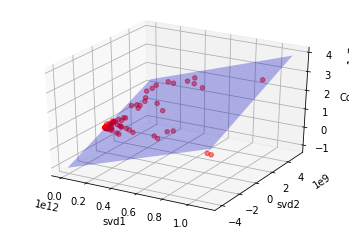

In [20]:
df2 = pd.DataFrame()

df2['x'] = lst0
df2['y'] = lst1
df2['Total Co']= lst2

x_surf, y_surf = np.meshgrid(np.linspace(df2.x.min(), df2.x.max(), 190),np.linspace(df2.y.min(), df2.y.max(), 190))
onlyX = pd.DataFrame({'x': x_surf.ravel(), 'y': y_surf.ravel()})
fittedY=reg_reduction.predict(onlyX)
fittedY = np.array(fittedY)

fittedY = np.array(fittedY)
fittedY = fittedY[:,0]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df2['x'],df2['y'],df2['Total Co'],c='red', marker='o', alpha=0.5)
ax.plot_surface(x_surf,y_surf,fittedY.reshape(x_surf.shape), color='b', alpha=0.3)
ax.set_xlabel('svd1')
ax.set_ylabel('svd2')
ax.set_zlabel('Co2')
plt.show()